In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score

## Experiment Parameters

In [2]:
# Experiment level
seed = 42
torch.manual_seed(seed) # set random seed for reproducibility

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 64
n_classes = 6

# Network parameters
hidden_dim = 256

# Training schedule
lr = 1e-4
epochs = 60

## Import sample data

In [3]:
root_dir = r'C:/Users/w37262do/Documents/git/lbp_3d/data/'
spectra_raw = np.load(root_dir+'all_raw_spectra.npy') 
spectra_trans = np.load(root_dir+'all_transformed_spectra.npy') * 1000
core_ids = np.load(root_dir+'all_core_indices.npy')
patient_ids = np.load(root_dir+'all_core_pids.npy')
tissue_classes = np.load(root_dir+'all_tissue_classes.npy')
wavenumbers_raw = np.load(root_dir+'wavenumbers.npy')
wavenumbers_trans = np.load(root_dir+'wavenumbers_dougal1_2nd.npy')
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(np.unique(tissue_classes))
print(f"Loaded {len(spectra_raw)} spectra from {len(np.unique(core_ids))} cores from {len(np.unique(patient_ids))} patients")

Loaded 49361 spectra from 228 cores from 100 patients


## Define data split, dataloaders and datasets


In [4]:
# split patients into train, val, test sets
unique_pids = np.unique(patient_ids)
pids_trainval, pids_test, _, _ = train_test_split(unique_pids, np.zeros_like(unique_pids), test_size=0.2, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(pids_trainval, np.zeros_like(pids_trainval), test_size=0.25, random_state=seed)
# Get indexes for which spectra are in each set
where_train = np.where(np.isin(patient_ids,pids_train))
where_val = np.where(np.isin(patient_ids,pids_val))
where_test = np.where(np.isin(patient_ids,pids_test))
print(f"Spectra per data split:\n\tTrain: {len(where_train[0])}\n\tVal: {len(where_val[0])}\n\tTest: {len(where_test[0])}")

Spectra per data split:
	Train: 29785
	Val: 9231
	Test: 10345


In [7]:
# define custom dataset class, inheriting from torch.utils.data.Dataset
# The three functions here must be defined when inheriting from torch.utils.data.Dataset
class spectra_dataset(torch.utils.data.Dataset):
    def __init__(self, spectra_raw, spectra_trans):
        self.spectra_raw = spectra_raw
        self.spectra_trans = spectra_trans

    # Function called to determine number of items in dataset
    def __len__(self):
        return len(self.spectra_raw)
        
    # Function called when retrieving a single item from dataset
    # Items are indexed from [0 -> self.__len__]
    def __getitem__(self, idx):
        # get spectrum at idx, then convert from numpy array to torch tensor
        spectrum = torch.from_numpy(self.spectra_raw[idx]).float() # torch (generally) expects float dtype for continuous data
        
        # get label, then convert it to a tensor also
        trans = torch.from_numpy(self.spectra_trans[idx]).float() # torch expects labels to be long int
        
        return spectrum.unsqueeze(-1).unsqueeze(-1), trans.unsqueeze(-1).unsqueeze(-1)

In [8]:
# define mean and std spectrum from train data

# Define dataset objects for each data split
dataset_train = spectra_dataset(
    spectra_raw[where_train], spectra_trans[where_train]
)

dataset_val = spectra_dataset(
    spectra_raw[where_val], spectra_trans[where_val]
)

dataset_test = spectra_dataset(
    spectra_raw[where_test], spectra_trans[where_test]
)

# define dataloader objects for each data split
# Batch size determines how many items are loaded and stacked together
# Drop last ensures that every item is used; odd-shaped final batch is still used.
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)
print(f"loader sizes:\n\ttrain: {len(train_loader)} batches\n\tval: {len(val_loader)} batches\n\ttest: {len(test_loader)} batches")

loader sizes:
	train: 466 batches
	val: 145 batches
	test: 162 batches


## Define network

In [25]:
class spectra_network(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input_norm = nn.BatchNorm2d(input_dim)
        
        self.activation = nn.GELU()
        
        self.autoenc = nn.Sequential(
            nn.Conv2d(input_dim,hidden_dim,kernel_size=1),
            self.activation,
            nn.BatchNorm2d(hidden_dim),
            nn.Conv2d(hidden_dim,hidden_dim,kernel_size=1),
            self.activation,
            nn.BatchNorm2d(hidden_dim),
            nn.Conv2d(hidden_dim,hidden_dim,kernel_size=1),
            self.activation,
            nn.BatchNorm2d(hidden_dim),
            nn.Conv2d(hidden_dim,output_dim,kernel_size=1),
        )
    
    def forward(self, x):
        x = self.input_norm(x)
        x = self.autoenc(x)
        return x

In [26]:
model = spectra_network(
    input_dim=spectra_raw.shape[-1],
    hidden_dim=hidden_dim,
    output_dim=spectra_trans.shape[-1],
)
print(f"model with {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.3f}M params")

model with 0.763M params


In [27]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Train loop

In [28]:
training_losses,validation_losses = [],[]
best_val_loss = 100000
best_val_epoch = 0

In [29]:
for epoch in range(epochs):
    print(f"\n ✰ ✰ ✰ EPOCH {epoch+1} ✰ ✰ ✰ ")
    
    # reset running metrics
    running_loss_train, running_loss_val = 0, 0
    
    # Train loop
    model.train() # sets model in training mode. this exclusively affects dropout and batch normalisation layers
    batch_frac = 42 / (len(train_loader)) # just for visualising progress
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"train : {'█'*int(batch_idx*batch_frac)}", end="\r")
        
        # Push data through model
        optimizer.zero_grad() # zeros gradients of optimiser, necessary to ensure backward pass is based on just the forward pass called just after
        out = model(data)
        
        # Calculate loss
        loss = loss_fn(out,label)
        loss.backward() # backpropagate to train network
        optimizer.step() # steps forward the optimiser, necessary for optimisers like adam which change every iteration
        
        # Calculate metrics
        running_loss_train += loss.cpu().item()
        
    print(f"train : {'█'*42}")
        
    # Validate loop
    model.eval() # sets model in evaluation mode. this exclusively affects dropout and batch normalisation layers
    batch_frac = 42 / len(val_loader)
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            print(f"val   : {'█'*int(batch_idx*batch_frac)}", end="\r")
            
            # Push data through model
            out = model(data)
            
            # Calculate loss
            loss = loss_fn(out,label) # no backpropagation on validaton set
            
            # Calculate metrics
            running_loss_val += loss.cpu().item()
            
    print(f"val   : {'█'*42}")
    
    # calculate epoch metrics for train set
    train_loss = running_loss_train / (len(train_loader)); training_losses.append(train_loss)
    
    # calculate epoch metrics for val set
    val_loss = running_loss_val / (len(val_loader)); validation_losses.append(val_loss)
    
    # Update
    print(f"TRAIN --- | Loss: {train_loss:.4}")
    print(f"VAL ----- | Loss: {val_loss:.4}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        torch.save(model.state_dict(), rf'./models/autoenc_model_{seed}.pt')

model.load_state_dict(torch.load(rf'./models/autoenc_model_{seed}.pt', weights_only=True))


 ✰ ✰ ✰ EPOCH 1 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.03336
VAL ----- | Loss: 0.007349

 ✰ ✰ ✰ EPOCH 2 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.003198
VAL ----- | Loss: 0.002478

 ✰ ✰ ✰ EPOCH 3 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.00177
VAL ----- | Loss: 0.002218

 ✰ ✰ ✰ EPOCH 4 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.001555
VAL ----- | Loss: 0.001987

 ✰ ✰ ✰ EPOCH 5 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : ██████████████████████████████████████████
TRAIN --- | Loss: 0.001368
VAL ----- | Loss: 0.001802

 ✰ ✰ ✰ EPOCH 6 ✰ ✰ ✰ 
train : ██████████████████████████████████████████
val   : █████████████████████████

<All keys matched successfully>

## Test Loop

In [30]:
# Test
running_loss_test = 0
test_preds, test_targets = [], []
model.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        # Push data through model
        out = model(data)
        
        # Calculate loss
        loss = loss_fn(out,label)
        
        # Calculate metrics
        running_loss_test += loss.cpu().item()

# calculate test set metrics
test_loss = running_loss_test / len(test_loader)

print(f"TEST ---- | Loss: {test_loss:.4}")

TEST ---- | Loss: 0.0001621


## Evaluate

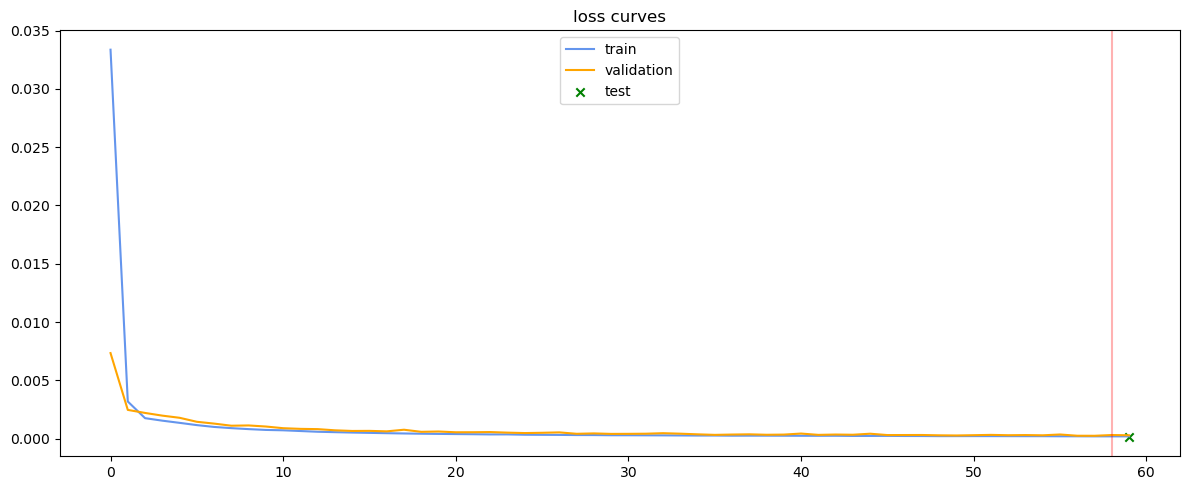

In [31]:
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(np.arange(0,len(training_losses)),np.array(training_losses),color='cornflowerblue',label="train")
ax.plot(np.arange(0,len(validation_losses)),np.array(validation_losses),color='orange',label="validation")
ax.scatter(len(validation_losses)-1,test_loss,color='green',label="test",marker="x")
ax.set_title("loss curves"); ax.legend()

ax.axvline(x=best_val_epoch+1, ymin=0, ymax=1, color='red',alpha=0.3)

plt.tight_layout()

## Show predictions

In [32]:
# load sample from test set
test_data_raw, test_data_trans = next(iter(test_loader))
out = model(test_data_raw).detach()

In [33]:
loss_fn(test_data_trans,out)

tensor(0.0002)

ValueError: x and y can be no greater than 2D, but have shapes (965,) and (965, 1, 1)

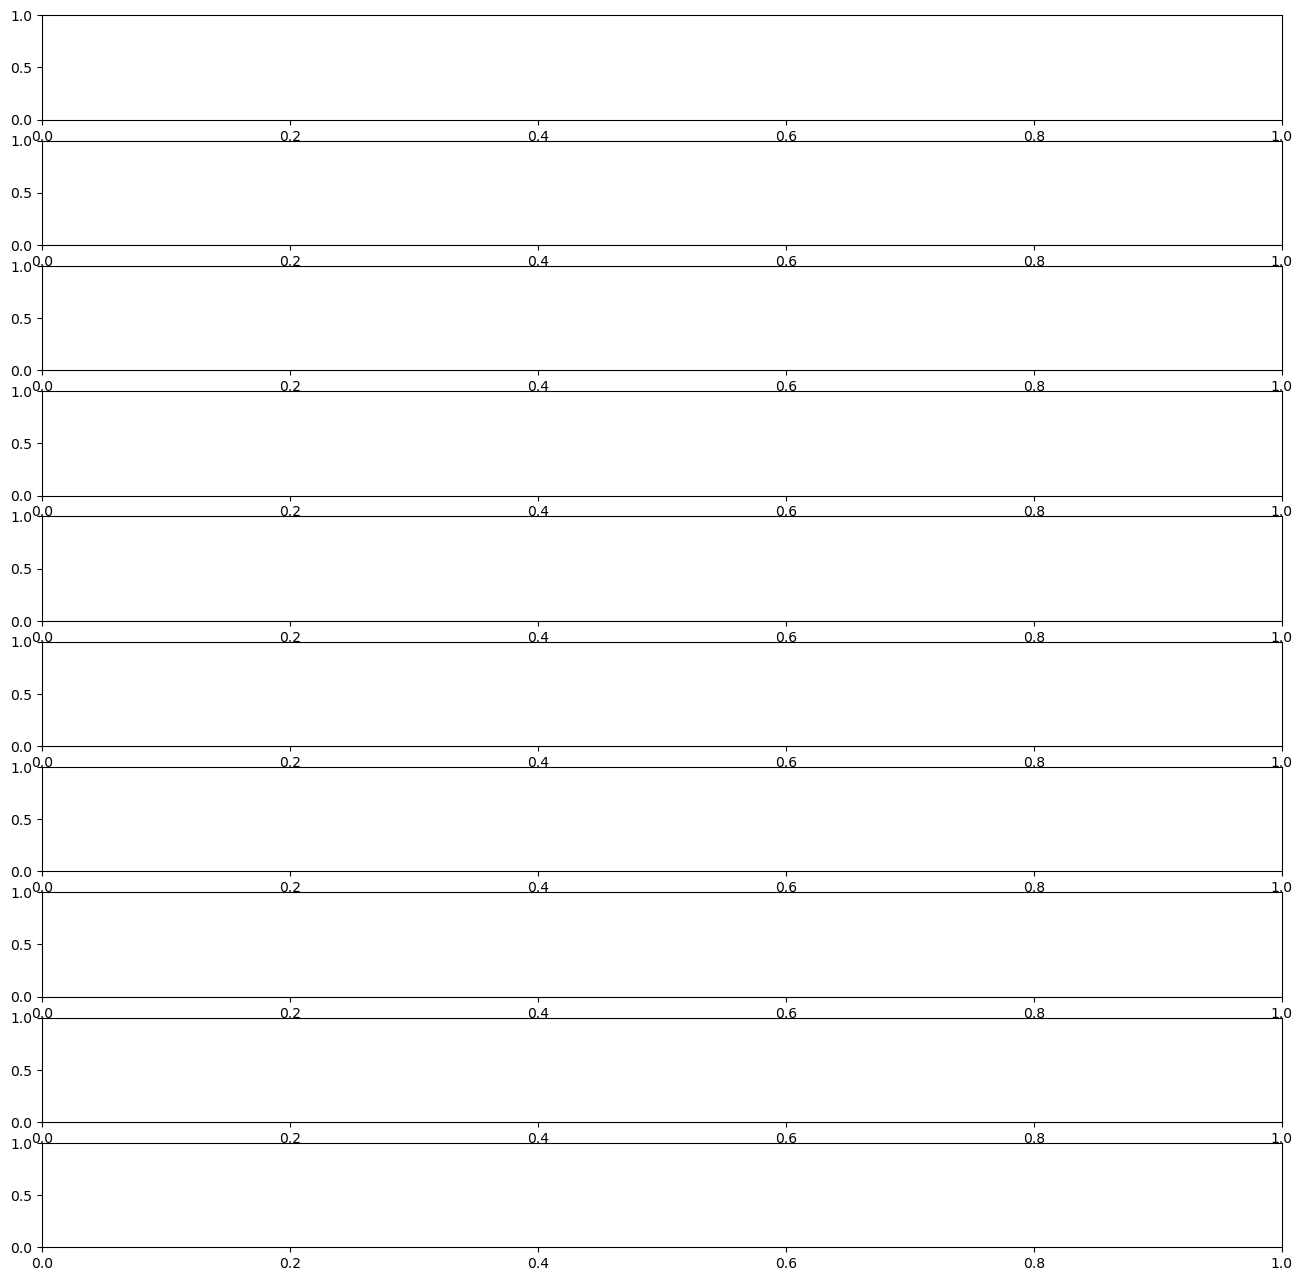

In [34]:
fig,ax = plt.subplots(10,1,figsize=(16,16)); ax = ax.flatten()
for x in range(10):
    ax[x].plot(wavenumbers_trans,test_data_trans[x],label="true trans",color='cornflowerblue',alpha=0.7)
    ax[x].plot(wavenumbers_trans,out[x],label="pred trans",color='orange',alpha=0.7)
fig.tight_layout()